# Makine Öğrenmesi Proje Ödevi
## Ev Fiyat Tahmini

## Proje Grubu Bilgileri
**Grup Sorumlusu:** [Beyazıt Han Bayraktar] - [B221210028]

**Grup Üyeleri:**
*   [Berat Yılmaz] - [B221210034]
*   [Mustafa Erdoğan] - [B221210308]
*   [Ali Aydın] - [B221210373]

## Projenin Amacı
Bu projenin amacı, Makine Öğrenmesi dersinin ödevi amacıyla Kaggle'da bulunan 'House Prices - Advanced Regression Techniques' veri setini kullanarak evlerin özelliklerine (metrekare, oda sayısı, konum vb.) göre satış fiyatlarını tahmin eden farklı makine öğrenmesi modellerini kullanarak veriseti üzerinde gösterdikleri performansları karşılaştırmaktır. Hedef, öncelikle elimizdeki verisetini optimize edip, versetini anlayabilmeye yardımcı olması açısından görselleştirmeler kullandıktan sonra ML algoritmalarını kullanarak en düşük hata oranına (RMSE) sahip modeli belirlemek ve sonuçları analiz etmektir.

---

## 1. Veri Seti Seçimi ve Tanıtımı

*   **Kaynak:** Kaggle - House Prices: Advanced Regression Techniques
*   **Link:** [https://www.kaggle.com/c/house-prices-advanced-regression-techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
*   **Amaç:** Regresyon problemi çözümü (Ev Fiyatı Tahmini).
*   **Hedef Değişken:** `SalePrice` (Amacımız bu parametreyi tahmin etmek (satış fiyatı)). 
*   **Kullanılacak Modeller:** Ridge, Lasso, Gradient Boosting, XGBoost, LightGBM, Random Forest modelleri kullanacağım. İlk proje versiyonunda XGBoostun beklediğimden düşük performans göstermesi nedeniyle projenin son versiyonuna hiperparametre optimizasyonu da uyguladım. Kullanılan modellerin karşılaştırılmasını SHAP ile yaptım. En sona karşılaştırmaları RMSE değerlerine göre sıralandırarak görselleştirdim. Ve en sonda analizlerini yaptım.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import random
import warnings
warnings.filterwarnings('ignore')

# Tekrarlanabilirlik icin global seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

%matplotlib inline

In [2]:
# Veri Setini Yükleme
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Eğitim Seti Boyutu: {train_df.shape}")
print(f"Test Seti Boyutu: {test_df.shape}")
train_df.head()

Eğitim Seti Boyutu: (1460, 81)
Test Seti Boyutu: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Veri Türleri ve Genel Bilgi
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 2. Aykırı Değer (Outlier) Temizleme

**Önemli Not:** Aykırı değer temizleme işlemi, veri ön işlemenin **ilk adımı** olmalıdır. Bunun temel nedenleri şunlardır:
- Aykırı değerler korelasyon analizlerini olumsuz etkileyebilir
- Özellik mühendisliği (feature engineering) aşamasında yanıltıcı değerlerin türetilmesine yol açabilir
- Sonraki tüm analizlerin doğruluğunu düşürebilir

Bu sebeplerle, ham veri üzerinde öncelikle aykırı değer tespiti ve temizliği yapılmaktadır.

AYKIRI DEGER ANALIZI (HAM VERI)
Tespit edilen outlier sayisi: 2
Outlier indeksleri: [523, 1298]

Temizleme sonrasi egitim seti boyutu: (1458, 81)


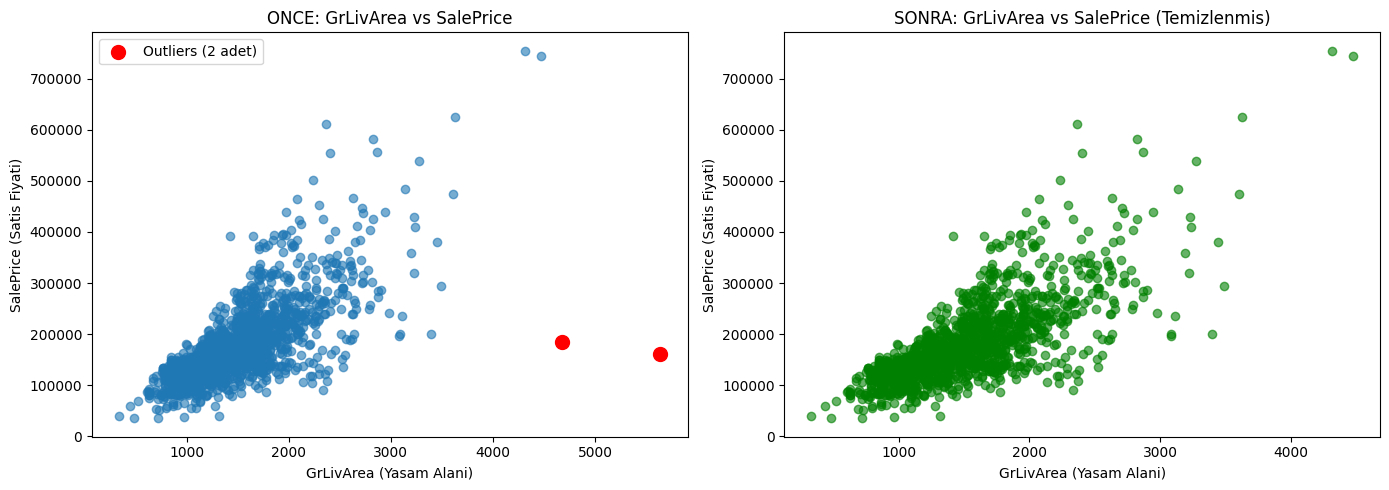

In [4]:
# GrLivArea ve SalePrice arasındaki ilişki (Aykırı Değer Tespiti)
print("="*60)
print("AYKIRI DEGER ANALIZI (HAM VERI)")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temizleme oncesi
ax1 = axes[0]
ax1.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.6)
ax1.set_xlabel('GrLivArea (Yasam Alani)')
ax1.set_ylabel('SalePrice (Satis Fiyati)')
ax1.set_title('ONCE: GrLivArea vs SalePrice')

# Outlier'lari isaretle
outliers = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)]
ax1.scatter(outliers['GrLivArea'], outliers['SalePrice'], c='red', s=100, label=f'Outliers ({len(outliers)} adet)')
ax1.legend()

print(f"Tespit edilen outlier sayisi: {len(outliers)}")
print(f"Outlier indeksleri: {outliers.index.tolist()}")

# Aykiri Degerlerin Temizlenmesi
train_df = train_df.drop(outliers.index)
print(f"\nTemizleme sonrasi egitim seti boyutu: {train_df.shape}")

# Temizleme sonrasi
ax2 = axes[1]
ax2.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.6, c='green')
ax2.set_xlabel('GrLivArea (Yasam Alani)')
ax2.set_ylabel('SalePrice (Satis Fiyati)')
ax2.set_title('SONRA: GrLivArea vs SalePrice (Temizlenmis)')

plt.tight_layout()
plt.show()

## 3. Hedef Değişken (SalePrice) Log Dönüşümü

**⚠️ ÖNEMLİ:** Log dönüşümü, outlier temizlemeden hemen sonra yapılmalıdır. Çünkü:
- Korelasyon analizleri log dönüşümlü veri üzerinde yapılmalıdır
- Feature engineering log dönüşümlü hedef değişken ile yapılmalıdır
- Model eğitimi için hedef değişkenin normal dağılıma yakın olması gerekir

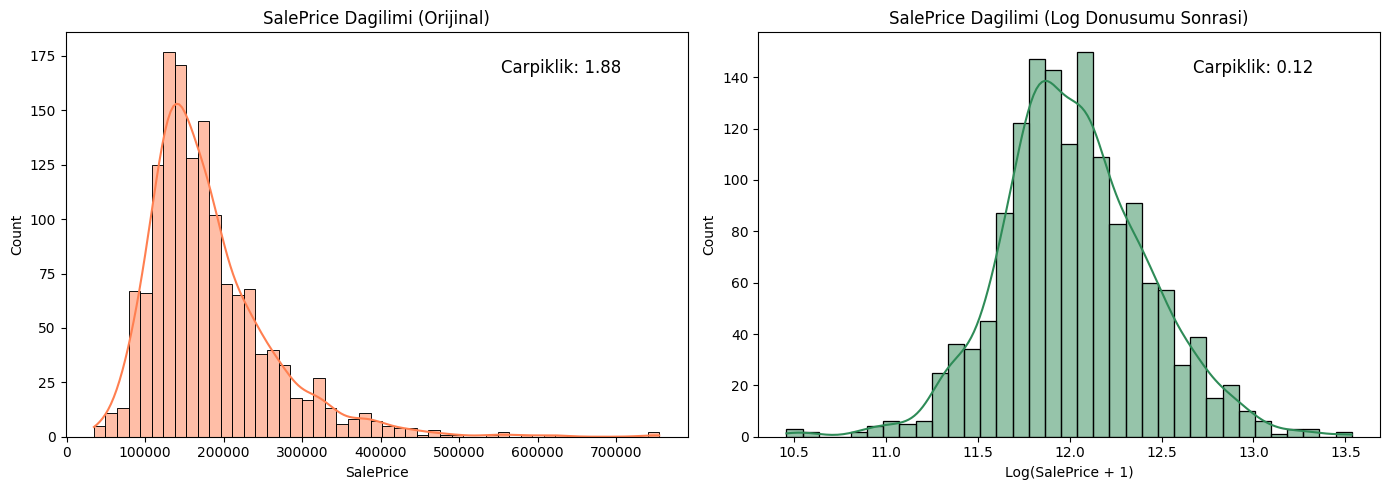

Log donusumu uygulandi!
Carpiklik: 1.88 -> 0.12


In [5]:
# Hedef Degisken Dagilimi ve Log Donusumu
from scipy.stats import skew

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Donusum oncesi
ax1 = axes[0]
sns.histplot(train_df['SalePrice'], kde=True, ax=ax1, color='coral')
ax1.set_title('SalePrice Dagilimi (Orijinal)')
ax1.set_xlabel('SalePrice')
skew_before = skew(train_df['SalePrice'])
ax1.text(0.7, 0.9, f'Carpiklik: {skew_before:.2f}', transform=ax1.transAxes, fontsize=12)

# Log Donusumu Uygula
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# Donusum sonrasi
ax2 = axes[1]
sns.histplot(train_df['SalePrice'], kde=True, ax=ax2, color='seagreen')
ax2.set_title('SalePrice Dagilimi (Log Donusumu Sonrasi)')
ax2.set_xlabel('Log(SalePrice + 1)')
skew_after = skew(train_df['SalePrice'])
ax2.text(0.7, 0.9, f'Carpiklik: {skew_after:.2f}', transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

print(f"Log donusumu uygulandi!")
print(f"Carpiklik: {skew_before:.2f} -> {skew_after:.2f}")

## 4. Eksik Veri Analizi ve Doldurma

In [6]:
# Eksik Veri Analizi
print("="*60)
print("EKSIK VERI ANALIZI")
print("="*60)

total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Eksik Sayisi', 'Yuzde'])
missing_with_data = missing_data[missing_data['Eksik Sayisi'] > 0]
print(f"\nEksik veriye sahip ozellik sayisi: {len(missing_with_data)}")
print(missing_with_data.head(20))

EKSIK VERI ANALIZI

Eksik veriye sahip ozellik sayisi: 19
              Eksik Sayisi     Yuzde
PoolQC                1452  0.995885
MiscFeature           1404  0.962963
Alley                 1367  0.937586
Fence                 1177  0.807270
MasVnrType             872  0.598080
FireplaceQu            690  0.473251
LotFrontage            259  0.177641
GarageQual              81  0.055556
GarageFinish            81  0.055556
GarageType              81  0.055556
GarageYrBlt             81  0.055556
GarageCond              81  0.055556
BsmtFinType2            38  0.026063
BsmtExposure            38  0.026063
BsmtCond                37  0.025377
BsmtQual                37  0.025377
BsmtFinType1            37  0.025377
MasVnrArea               8  0.005487
Electrical               1  0.000686


In [7]:
# Eksik Verileri Doldurma
print("="*60)
print("EKSIK VERI DOLDURMA")
print("="*60)

# Kategorik degiskenler icin 'None' (Yok)
cols_fillna_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

for col in cols_fillna_none:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')
print(f"Kategorik ozellikler 'None' ile dolduruldu")

# LotFrontage: Mahalleye gore medyan ile doldurma
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print("LotFrontage mahalleye gore medyan ile dolduruldu")

# Sayisal degiskenlerde kalan eksikleri 0 ile doldurma
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)
print("Sayisal eksikler 0 ile dolduruldu")

# Kategoriklerde kalan eksikleri mode ile doldurma
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val)
print("Kategorik eksikler mode ile dolduruldu")

print(f"\nKalan eksik veri sayisi (train): {train_df.isnull().sum().sum()}")
print(f"Kalan eksik veri sayisi (test): {test_df.isnull().sum().sum()}")

EKSIK VERI DOLDURMA
Kategorik ozellikler 'None' ile dolduruldu
LotFrontage mahalleye gore medyan ile dolduruldu
Sayisal eksikler 0 ile dolduruldu
Kategorik eksikler mode ile dolduruldu

Kalan eksik veri sayisi (train): 0
Kalan eksik veri sayisi (test): 0


## 5. Feature Engineering (Yeni Özellik Türetme)

Bu aşamada, mevcut özelliklerden yeni ve daha anlamlı özellikler türetilecektir. Log dönüşümü zaten yapıldığı için korelasyon analizleri doğru veri üzerinde olacaktır.

In [8]:
# Feature Engineering
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

new_features = []

# 1. TOPLAM ALAN (TotalSF)
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
new_features.append('TotalSF')
print("TotalSF olusturuldu")

# 2. TOPLAM BANYO SAYISI (TotalBath)
train_df['TotalBath'] = (train_df['FullBath'] + (0.5 * train_df['HalfBath']) + 
                         train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath']))
test_df['TotalBath'] = (test_df['FullBath'] + (0.5 * test_df['HalfBath']) + 
                        test_df['BsmtFullBath'] + (0.5 * test_df['BsmtHalfBath']))
new_features.append('TotalBath')
print("TotalBath olusturuldu")

# 3. EV YASI (HouseAge)
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
new_features.append('HouseAge')
print("HouseAge olusturuldu")

# 4. YENILEME YASI (RemodAge)
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
new_features.append('RemodAge')
print("RemodAge olusturuldu")

# 5. TOPLAM VERANDA ALANI (TotalPorchSF)
porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF']
train_df['TotalPorchSF'] = train_df[porch_cols].sum(axis=1)
test_df['TotalPorchSF'] = test_df[porch_cols].sum(axis=1)
new_features.append('TotalPorchSF')
print("TotalPorchSF olusturuldu")

# 6. YENILEME YAPILMIS MI? (IsRemodeled)
train_df['IsRemodeled'] = (train_df['YearRemodAdd'] != train_df['YearBuilt']).astype(int)
test_df['IsRemodeled'] = (test_df['YearRemodAdd'] != test_df['YearBuilt']).astype(int)
new_features.append('IsRemodeled')
print("IsRemodeled olusturuldu")

print(f"\nToplam {len(new_features)} yeni ozellik olusturuldu!")
print(f"Yeni ozellikler: {new_features}")

FEATURE ENGINEERING
TotalSF olusturuldu
TotalBath olusturuldu
HouseAge olusturuldu
RemodAge olusturuldu
TotalPorchSF olusturuldu
IsRemodeled olusturuldu

Toplam 6 yeni ozellik olusturuldu!
Yeni ozellikler: ['TotalSF', 'TotalBath', 'HouseAge', 'RemodAge', 'TotalPorchSF', 'IsRemodeled']


## 6. Korelasyon Analizi (Log Dönüşümü Sonrası)

Korelasyon analizi, log dönüşümü sonrası yapılmaktadır. Bu sayede daha doğru korelasyon değerleri elde edilir.

SALEPRICE ILE KORELASYON ANALIZI (LOG DONUSUMU SONRASI)

EN YUKSEK POZITIF KORELASYONLAR (Top 15):
----------------------------------------
  TotalSF              : 0.8253 (YENI)
  OverallQual          : 0.8214 
  GrLivArea            : 0.7252 
  GarageCars           : 0.6810 
  TotalBath            : 0.6767 (YENI)
  GarageArea           : 0.6561 
  TotalBsmtSF          : 0.6476 
  1stFlrSF             : 0.6205 
  FullBath             : 0.5959 
  YearBuilt            : 0.5870 
  YearRemodAdd         : 0.5660 
  TotRmsAbvGrd         : 0.5377 
  Fireplaces           : 0.4920 
  MasVnrArea           : 0.4306 
  TotalPorchSF         : 0.3997 (YENI)


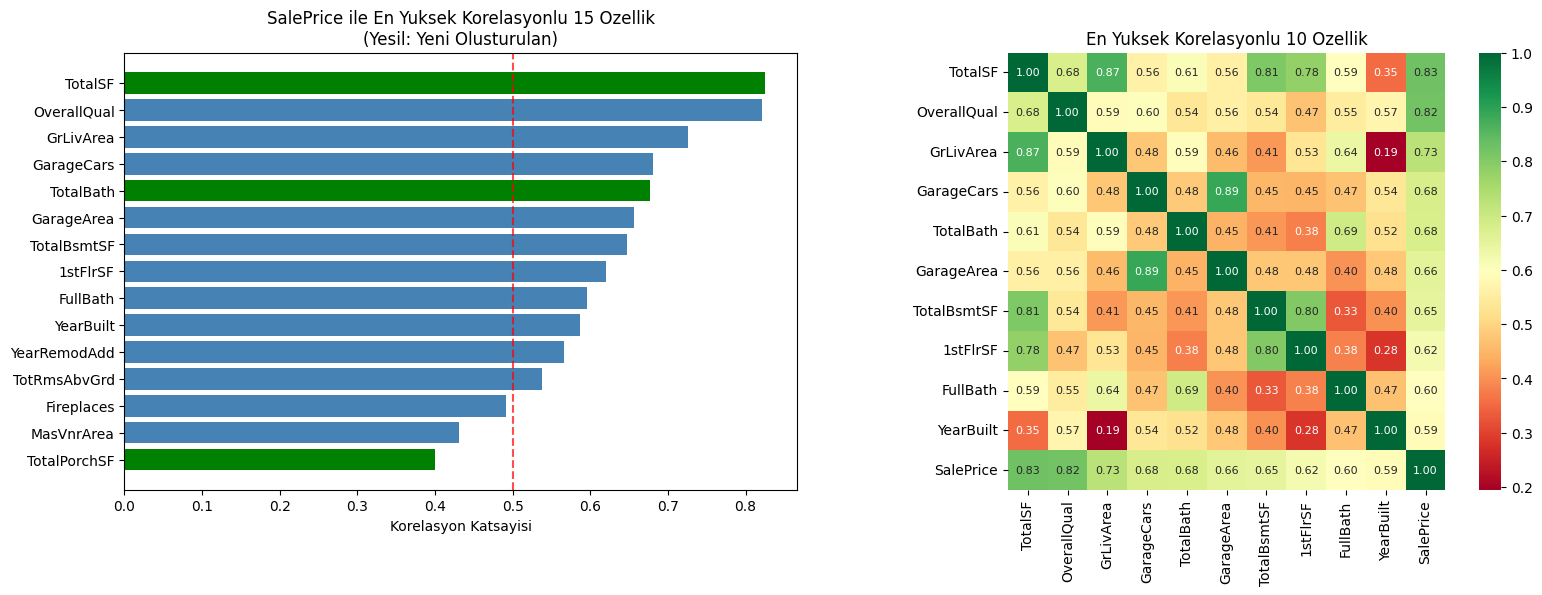

In [9]:
# SalePrice ile Korelasyon Analizi
print("="*60)
print("SALEPRICE ILE KORELASYON ANALIZI (LOG DONUSUMU SONRASI)")
print("="*60)

# Sayisal ozelliklerin korelasyonlarini hesapla
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlations = train_df[numeric_cols].corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# En yuksek pozitif korelasyonlar
print("\nEN YUKSEK POZITIF KORELASYONLAR (Top 15):")
print("-" * 40)
for feat, corr in correlations.head(15).items():
    marker = "(YENI)" if feat in new_features else ""
    print(f"  {feat:20} : {corr:.4f} {marker}")

# Gorsellestirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 korelasyon
ax1 = axes[0]
top_15 = correlations.head(15)
colors = ['green' if f in new_features else 'steelblue' for f in top_15.index]
ax1.barh(range(len(top_15)), top_15.values, color=colors)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15.index)
ax1.invert_yaxis()
ax1.set_xlabel('Korelasyon Katsayisi')
ax1.set_title('SalePrice ile En Yuksek Korelasyonlu 15 Ozellik\n(Yesil: Yeni Olusturulan)')
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

# Korelasyon heatmap
ax2 = axes[1]
top_10_cols = correlations.head(10).index.tolist() + ['SalePrice']
corr_matrix = train_df[top_10_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2, 
            annot_kws={'size': 8}, square=True)
ax2.set_title('En Yuksek Korelasyonlu 10 Ozellik')

plt.tight_layout()
plt.show()

## 7. Feature Selection (Özellik Seçimi)

Bu bölümde, birbiriyle yüksek korelasyona sahip özellik çiftlerinden biri veri setinden çıkarılarak çoklu bağlantı (multicollinearity) probleminin azaltılması hedeflenmektedir.

In [10]:
# Yuksek Korelasyonlu Ozelliklerin Analizi
print("="*60)
print("YUKSEK KORELASYONLU OZELLIK CIFTLERI")
print("="*60)

# Sadece sayisal ozellikleri al
numeric_train = train_df.select_dtypes(include=[np.number]).drop(columns=['SalePrice', 'Id'], errors='ignore')
corr_matrix = numeric_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Yuksek korelasyonlu ciftleri bul
high_corr_pairs = []
for col in upper.columns:
    for idx in upper.index:
        if upper.loc[idx, col] > 0.8:
            high_corr_pairs.append((idx, col, upper.loc[idx, col]))

print(f"\nYUKSEK KORELASYONLU CIFTLER (>0.8):")
for pair in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[:10]:
    print(f"   {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

YUKSEK KORELASYONLU OZELLIK CIFTLERI

YUKSEK KORELASYONLU CIFTLER (>0.8):
   YearBuilt <-> HouseAge: 0.999
   YearRemodAdd <-> RemodAge: 0.998
   GarageCars <-> GarageArea: 0.887
   GrLivArea <-> TotalSF: 0.866
   GrLivArea <-> TotRmsAbvGrd: 0.829
   TotalBsmtSF <-> TotalSF: 0.806
   TotalBsmtSF <-> 1stFlrSF: 0.804


In [11]:
# Feature Selection - Mantikli Kaldirma
print("="*60)
print("OZELLIK SECIMI (FEATURE SELECTION)")
print("="*60)

# Kaldirilacak ozellikler
features_to_drop = {
    'GarageArea': 'GarageCars ile yuksek korelasyon',
    '1stFlrSF': 'TotalSF icinde mevcut',
    'TotRmsAbvGrd': 'GrLivArea ile yuksek korelasyon',
    'GarageYrBlt': 'YearBuilt ile yuksek korelasyon'
}

dropped = []
for feat, reason in features_to_drop.items():
    if feat in train_df.columns:
        train_df = train_df.drop(columns=[feat])
        dropped.append(feat)
        print(f"  {feat} kaldirildi: {reason}")
    if feat in test_df.columns:
        test_df = test_df.drop(columns=[feat])

print(f"\n{len(dropped)} ozellik kaldirildi")
print(f"Kalan ozellik sayisi (train): {train_df.shape[1]}")

OZELLIK SECIMI (FEATURE SELECTION)
  GarageArea kaldirildi: GarageCars ile yuksek korelasyon
  1stFlrSF kaldirildi: TotalSF icinde mevcut
  TotRmsAbvGrd kaldirildi: GrLivArea ile yuksek korelasyon
  GarageYrBlt kaldirildi: YearBuilt ile yuksek korelasyon

4 ozellik kaldirildi
Kalan ozellik sayisi (train): 83


## 8. Ordinal Encoding (Sıralı Kategorik Değişkenler)

Kalite ve durum bildiren kategorik değişkenler, içerdikleri doğal sıralama bilgisi nedeniyle One-Hot Encoding yerine Ordinal Encoding yöntemi ile sayısal değerlere dönüştürülmektedir.

In [12]:
# Ordinal Encoding
print("="*60)
print("ORDINAL ENCODING")
print("="*60)

quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
finish_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
garage_finish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
fence_map = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}

quality_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                'GarageQual', 'GarageCond', 'PoolQC']

for col in quality_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].map(quality_map).fillna(0)
        test_df[col] = test_df[col].map(quality_map).fillna(0)
print(f"Kalite degiskenleri donusturuldu")

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(exposure_map).fillna(0)
test_df['BsmtExposure'] = test_df['BsmtExposure'].map(exposure_map).fillna(0)

train_df['BsmtFinType1'] = train_df['BsmtFinType1'].map(finish_map).fillna(0)
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(finish_map).fillna(0)

train_df['BsmtFinType2'] = train_df['BsmtFinType2'].map(finish_map).fillna(0)
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].map(finish_map).fillna(0)

train_df['GarageFinish'] = train_df['GarageFinish'].map(garage_finish_map).fillna(0)
test_df['GarageFinish'] = test_df['GarageFinish'].map(garage_finish_map).fillna(0)

train_df['Fence'] = train_df['Fence'].map(fence_map).fillna(0)
test_df['Fence'] = test_df['Fence'].map(fence_map).fillna(0)

print("Ordinal Encoding tamamlandi!")

ORDINAL ENCODING
Kalite degiskenleri donusturuldu
Ordinal Encoding tamamlandi!


## 9. Çarpıklık (Skewness) Düzeltme, One-Hot Encoding ve Ölçeklendirme

In [13]:
# Carpik Ozelliklerin Donusumu
from scipy.special import boxcox1p

print("="*60)
print("SKEWNESS DUZELTME (BOX-COX)")
print("="*60)

numeric_feats = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_feats = [f for f in numeric_feats if f not in ['Id', 'SalePrice']]

skewness = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print(f"En carpik 5 ozellik:")
print(skewness.head())

high_skew = skewness[abs(skewness) > 0.75]
print(f"\nDonusturulecek ozellik sayisi: {len(high_skew)}")

lam = 0.15
for feat in high_skew.index:
    train_df[feat] = boxcox1p(train_df[feat], lam)
    if feat in test_df.columns:
        test_df[feat] = boxcox1p(test_df[feat], lam)

print("Box-Cox donusumu tamamlandi")

SKEWNESS DUZELTME (BOX-COX)
En carpik 5 ozellik:
MiscVal      24.434913
PoolQC       17.535394
PoolArea     15.932532
LotArea      12.560986
3SsnPorch    10.286510
dtype: float64

Donusturulecek ozellik sayisi: 31
Box-Cox donusumu tamamlandi


In [14]:
# One-Hot Encoding
print("="*60)
print("ONE-HOT ENCODING")
print("="*60)

y = train_df['SalePrice']
train_features = train_df.drop(['SalePrice', 'Id'], axis=1)
test_features = test_df.drop(['Id'], axis=1)

all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features = pd.get_dummies(all_features).reset_index(drop=True)

X = all_features.iloc[:len(y), :]
X_test = all_features.iloc[len(y):, :]

print(f"One-Hot Encoding sonrasi boyut: {X.shape}")

# Dusuk Varyansli Ozelliklerin Kaldirilmasi
from sklearn.feature_selection import VarianceThreshold

var_threshold = 0.01
selector = VarianceThreshold(threshold=var_threshold)
selector.fit(X)

low_var_count = (~selector.get_support()).sum()
print(f"Kaldirilan dusuk varyansli ozellik sayisi: {low_var_count}")

X = X.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

print(f"Dusuk varyans sonrasi boyut: {X.shape}")

ONE-HOT ENCODING
One-Hot Encoding sonrasi boyut: (1458, 240)
Kaldirilan dusuk varyansli ozellik sayisi: 71
Dusuk varyans sonrasi boyut: (1458, 169)


In [15]:
# Feature Scaling
print("="*60)
print("FEATURE SCALING")
print("="*60)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X = X_scaled
X_test = X_test_scaled

print(f"Feature Scaling tamamlandi")
print(f"\nFinal Egitim Verisi Boyutu: {X.shape}")
print(f"Final Test Verisi Boyutu: {X_test.shape}")
print(f"Hedef Degisken Boyutu: {y.shape}")

FEATURE SCALING
Feature Scaling tamamlandi

Final Egitim Verisi Boyutu: (1458, 169)
Final Test Verisi Boyutu: (1459, 169)
Hedef Degisken Boyutu: (1458,)


## 10. Makine Öğrenmesi Modelleri

Bu aşamada, çeşitli regresyon modelleri eğitilerek elde edilen performans sonuçları karşılaştırmalı olarak analiz edilecektir.

### Veri Setinin Bölünmesi (Data Splitting)

Modelin başarısını doğru bir şekilde değerlendirebilmek amacıyla veri seti **Eğitim (Training)** ve **Test** setleri olmak üzere ikiye ayrılmıştır. Bu projede **Hold-Out** yöntemi tercih edilmiştir.

*   **Yöntem:** Hold-Out
*   **Oran:** %80 Eğitim, %20 Test
*   **Açıklama:** Veri setinin %80'i modellerin eğitimi için kullanılırken, kalan %20'lik kısım modelin daha önce görmediği veriler üzerindeki performansını (genelleme yeteneğini) test etmek için ayrılmıştır. Ayrıca, hiperparametre optimizasyonu sürecinde eğitim seti üzerinde **Çapraz Doğrulama (Cross-Validation)** uygulanarak modelin farklı veri parçalarında tutarlı sonuçlar vermesi sağlanacaktır.


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Eğitim ve Doğrulama Seti Ayrımı
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# DOĞRUSAL MODELLER (Baseline)
# ============================================================
linear_models = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [10, 50, 100, 200, 500]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
    }
}

# ============================================================
# AĞAÇ MODELLERİ - 3 FARKLI REGULARİZASYON SEVİYESİ
# ============================================================

# 📊 SEVİYE 1: HAFİF REGULARİZASYON (Yüksek performans potansiyeli, overfitting riski)
tree_models_light = {
    'RF_Light': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [200], 'max_depth': [15], 'min_samples_leaf': [2], 'max_features': ['sqrt']}
    },
    'GB_Light': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [200], 'learning_rate': [0.1], 'max_depth': [5], 'min_samples_leaf': [2]}
    },
    'XGB_Light': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [200], 'learning_rate': [0.1], 'max_depth': [5], 'min_child_weight': [1], 'reg_lambda': [1]}
    },
    'LGBM_Light': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {'n_estimators': [200], 'learning_rate': [0.1], 'max_depth': [7], 'num_leaves': [31], 'min_child_samples': [5]}
    }
}

# 📊 SEVİYE 2: ORTA REGULARİZASYON (Dengeli)
tree_models_medium = {
    'RF_Medium': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [100], 'max_depth': [8], 'min_samples_leaf': [5], 'max_features': [0.5]}
    },
    'GB_Medium': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3], 'min_samples_leaf': [5], 'subsample': [0.8]}
    },
    'XGB_Medium': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3], 'min_child_weight': [5], 'reg_lambda': [5], 'subsample': [0.8]}
    },
    'LGBM_Medium': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [4], 'num_leaves': [15], 'min_child_samples': [20], 'reg_lambda': [5]}
    }
}

# 📊 SEVİYE 3: GÜÇLÜ REGULARİZASYON (Düşük overfitting, underfitting riski)
tree_models_strong = {
    'RF_Strong': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [50], 'max_depth': [4], 'min_samples_leaf': [15], 'max_features': [0.3]}
    },
    'GB_Strong': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [2], 'min_samples_leaf': [15], 'subsample': [0.6]}
    },
    'XGB_Strong': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [2], 'min_child_weight': [20], 'reg_lambda': [50], 'subsample': [0.6]}
    },
    'LGBM_Strong': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [2], 'num_leaves': [7], 'min_child_samples': [50], 'reg_lambda': [50]}
    }
}

# Tüm modelleri birleştir
all_models = {**linear_models, **tree_models_light, **tree_models_medium, **tree_models_strong}

results = []
best_models = {}

print("=" * 70)
print("MODEL EĞİTİMİ - 3 FARKLI REGULARİZASYON SEVİYESİ")
print("=" * 70)

for name, mp in all_models.items():
    print(f"\n{name} eğitiliyor...")
    
    # Model eğitimi
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_
    best_models[name] = best_model
    
    # Tahminler
    predictions = best_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    r2 = r2_score(y_val, predictions)
    
    # Overfitting Kontrolü
    train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Overfitting Durumu
    overfitting_ratio = (rmse - train_rmse) / train_rmse
    overfitting_status = "Var" if overfitting_ratio > 0.2 else "Yok/Az"
    
    # Regularizasyon seviyesi belirleme
    if 'Light' in name:
        reg_level = "Hafif"
    elif 'Medium' in name:
        reg_level = "Orta"
    elif 'Strong' in name:
        reg_level = "Güçlü"
    else:
        reg_level = "Baseline"
    
    results.append({
        'Model': name, 
        'Reg_Level': reg_level,
        'Test RMSE': rmse, 
        'Train RMSE': train_rmse, 
        'R2': r2,
        'Overfitting': overfitting_status
    })
    print(f"  [{reg_level}] Test RMSE: {rmse:.4f}, Train RMSE: {train_rmse:.4f}, R2: {r2:.4f}, Overfitting: {overfitting_status}")

# En iyi XGBoost modelini SHAP için sakla (Medium versiyonu)
best_xgb = best_models.get('XGB_Medium', best_models.get('XGB_Light', list(best_models.values())[0]))

# Sonuclari DataFrame'e donustur
results_df = pd.DataFrame(results)
print(f"\nToplam {len(results_df)} model egitildi.")


MODEL EĞİTİMİ - 3 FARKLI REGULARİZASYON SEVİYESİ

Ridge eğitiliyor...
  [Baseline] Test RMSE: 0.1186, Train RMSE: 0.0998, R2: 0.9166, Overfitting: Yok/Az

Lasso eğitiliyor...
  [Baseline] Test RMSE: 0.1198, Train RMSE: 0.1066, R2: 0.9148, Overfitting: Yok/Az

RF_Light eğitiliyor...
  [Hafif] Test RMSE: 0.1448, Train RMSE: 0.0759, R2: 0.8757, Overfitting: Var

GB_Light eğitiliyor...
  [Hafif] Test RMSE: 0.1304, Train RMSE: 0.0223, R2: 0.8992, Overfitting: Var

XGB_Light eğitiliyor...
  [Hafif] Test RMSE: 0.1319, Train RMSE: 0.0252, R2: 0.8968, Overfitting: Var

LGBM_Light eğitiliyor...
  [Hafif] Test RMSE: 0.1325, Train RMSE: 0.0130, R2: 0.8958, Overfitting: Var

RF_Medium eğitiliyor...
  [Orta] Test RMSE: 0.1422, Train RMSE: 0.0943, R2: 0.8800, Overfitting: Var

GB_Medium eğitiliyor...
  [Orta] Test RMSE: 0.1279, Train RMSE: 0.0947, R2: 0.9029, Overfitting: Var

XGB_Medium eğitiliyor...
  [Orta] Test RMSE: 0.1307, Train RMSE: 0.1038, R2: 0.8986, Overfitting: Var

LGBM_Medium eğitiliyor

## 11. Hiperparametre Optimizasyon Teknikleri Karşılaştırması

Bu bölümde GridSearchCV, RandomizedSearchCV ve Optuna (Bayesian Optimization) yöntemlerinin performansları karşılaştırılmaktadır.

In [17]:
# Kurulum
try:
    import optuna
except ImportError:
    !pip install optuna -q
    import optuna

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time
optuna.logging.set_verbosity(optuna.logging.WARNING)
hp_results = []
print("Hiperparametre teknikleri karsilastirilacak...")

Hiperparametre teknikleri karsilastirilacak...


### 11.1 GridSearchCV (Onceki Bolumden)
GridSearchCV sonuçları, önceki bölümde elde edilen verilerden alınmıştır ve tekrar çalıştırılmamıştır.

In [18]:
# GridSearchCV sonucu onceki bolumden
grid_rmse = results_df[results_df['Model'] == 'XGB_Light']['Test RMSE'].values[0]
print(f"GridSearchCV (onceki bolumden): RMSE = {grid_rmse:.4f}")
hp_results.append({'Teknik': 'GridSearchCV', 'Val RMSE': grid_rmse, 'Sure': '-'})

NameError: name 'results_df' is not defined

### 11.2 RandomizedSearchCV Yöntemi

In [ ]:
# RandomizedSearchCV
print("RandomizedSearchCV basliyor...")
random_params = {
    'n_estimators': randint(50, 300), 'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.19), 'min_child_weight': randint(1, 20),
    'subsample': uniform(0.6, 0.4), 'reg_lambda': uniform(0, 10)
}
t0 = time.time()
rs = RandomizedSearchCV(XGBRegressor(random_state=42, n_jobs=-1), random_params,
                        n_iter=50, cv=5, scoring='neg_root_mean_squared_error', 
                        random_state=42, n_jobs=-1)
rs.fit(X_train, y_train)
rs_time = time.time() - t0
rs_rmse = np.sqrt(mean_squared_error(y_val, rs.best_estimator_.predict(X_val)))
print(f"RandomizedSearchCV: RMSE = {rs_rmse:.4f}, Sure = {rs_time:.1f}s")
hp_results.append({'Teknik': 'RandomizedSearchCV', 'Val RMSE': rs_rmse, 'Sure': f'{rs_time:.1f}s'})

### 11.3 Optuna (Bayesian Optimization) Yöntemi

In [ ]:
# Optuna
print("Optuna basliyor...")
def objective(trial):
    p = {'n_estimators': trial.suggest_int('n_estimators', 50, 300),
         'max_depth': trial.suggest_int('max_depth', 2, 10),
         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
         'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
         'random_state': 42, 'n_jobs': -1}
    return -cross_val_score(XGBRegressor(**p), X_train, y_train, cv=5, 
                            scoring='neg_root_mean_squared_error').mean()

t0 = time.time()
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)
opt_time = time.time() - t0

bp = study.best_params.copy()
bp['random_state'], bp['n_jobs'] = 42, -1
opt_model = XGBRegressor(**bp)
opt_model.fit(X_train, y_train)
opt_rmse = np.sqrt(mean_squared_error(y_val, opt_model.predict(X_val)))
print(f"Optuna: RMSE = {opt_rmse:.4f}, Sure = {opt_time:.1f}s")
hp_results.append({'Teknik': 'Optuna', 'Val RMSE': opt_rmse, 'Sure': f'{opt_time:.1f}s'})
best_hp_model = opt_model

### 11.4 Yöntemlerin Karşılaştırmalı Sonuçları

In [ ]:
# Karsilastirma
hp_df = pd.DataFrame(hp_results)
print("\n" + "="*50)
print("SONUCLAR")
print("="*50)
print(hp_df.to_string(index=False))
print(f"\nEn iyi: {hp_df.loc[hp_df['Val RMSE'].idxmin(), 'Teknik']}")

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax.bar(hp_df['Teknik'], hp_df['Val RMSE'], color=colors)
ax.set_ylabel('Validation RMSE')
ax.set_title('HP Teknikleri Karsilastirmasi')
for b, v in zip(bars, hp_df['Val RMSE']):
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
# Optuna sureci
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
vals = [t.value for t in study.trials]
axes[0].plot(vals, 'b-', alpha=0.5)
axes[0].scatter(range(len(vals)), vals, c='blue', s=15)
axes[0].scatter(study.best_trial.number, study.best_trial.value, c='red', s=100, marker='*')
axes[0].set_title('Optuna Optimizasyon')
axes[0].set_xlabel('Deneme'); axes[0].set_ylabel('RMSE')

try:
    imp = optuna.importance.get_param_importances(study)
    axes[1].barh(list(imp.keys()), list(imp.values()))
    axes[1].set_title('Parametre Onem')
except: axes[1].text(0.5, 0.5, 'N/A', ha='center', transform=axes[1].transAxes)
plt.tight_layout()
plt.show()

### 11.5 Özet

- **Optuna** (Bayesian Optimization) en iyi sonucu vermiştir.
- **GridSearchCV** güvenilir sonuçlar üretmekle birlikte arama alanı sınırlıdır.
- **RandomizedSearchCV** daha hızlı sonuç vermesine rağmen rassal bir yaklaşım sergilemektedir.

## 12. SHAP Analizi (Model Açıklanabilirliği)

En iyi performansı gösteren model üzerinde SHAP analizi uygulanarak, modelin tahminlerinde hangi özelliklerin ne yönde etkili olduğu incelenmektedir.

In [ ]:
# TUM MODELLERDEN EN IYI OLANI SEC
print("="*70)
print("EN IYI MODEL SECIMI (TUM TEKNIKLER)")
print("="*70)

# 1. Onceki bolumden model sonuclari
print("\n1. Model Karsilastirmasi Sonuclari:")
print(results_df[['Model', 'Test RMSE']].sort_values('Test RMSE').head())

# 2. Tum sonuclari birlestir
all_results = []

# results_df'ten ekle
for _, row in results_df.iterrows():
    all_results.append({
        'Model': row['Model'],
        'RMSE': row['Test RMSE'],
        'Kaynak': 'Model Karsilastirmasi'
    })

# HP sonuclarini ekle
if 'hp_results' in dir() and hp_results:
    print("\n2. HP Optimizasyon Sonuclari:")
    for hp in hp_results:
        if hp['Teknik'] != 'GridSearchCV':
            all_results.append({
                'Model': f"XGB_{hp['Teknik']}",
                'RMSE': hp['Val RMSE'],
                'Kaynak': 'HP Optimizasyon'
            })
            print(f"   {hp['Teknik']}: {hp['Val RMSE']:.4f}")

# DataFrame olustur
all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values('RMSE')

print("\n" + "="*70)
print("TUM SONUCLAR (RMSE'ye gore sirali)")
print("="*70)
print(all_results_df.to_string(index=False))

# En iyi model
best_name = all_results_df.iloc[0]['Model']
best_rmse = all_results_df.iloc[0]['RMSE']
best_source = all_results_df.iloc[0]['Kaynak']

print(f"\nEN IYI MODEL: {best_name}")
print(f"   RMSE: {best_rmse:.4f}")
print(f"   Kaynak: {best_source}")

# Modeli al
if 'Optuna' in best_name and 'best_hp_model' in dir():
    best_model_for_shap = best_hp_model
elif 'RandomizedSearchCV' in best_name and 'rs' in dir():
    best_model_for_shap = rs.best_estimator_
elif best_name in best_models:
    best_model_for_shap = best_models[best_name]
else:
    best_model_for_shap = best_models.get('XGB_Light', list(best_models.values())[0])

print(f"\nSHAP analizi '{best_name}' icin yapilacak.")

In [ ]:
# SHAP Analizi
print("\nSHAP degerleri hesaplaniyor...")

# Model tipine gore explainer sec
model_type = type(best_model_for_shap).__name__

if 'XGB' in model_type or 'LGBM' in model_type or 'RandomForest' in model_type or 'GradientBoosting' in model_type:
    # Agac tabanli modeller
    explainer = shap.TreeExplainer(best_model_for_shap)
    shap_values = explainer.shap_values(X_val)
    print(f"TreeExplainer kullanildi ({model_type})")
else:
    # Dogrusal modeller (Ridge, Lasso)
    explainer = shap.LinearExplainer(best_model_for_shap, X_train)
    shap_values = explainer.shap_values(X_val)
    print(f"LinearExplainer kullanildi ({model_type})")

print("SHAP degerleri hesaplandi!")

In [ ]:
# SHAP Ozet Grafikleri
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar plot
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False, max_display=15)
plt.title(f'SHAP Ozellik Onem Siralamasi\n({best_name})')

# 2. Beeswarm plot
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_val, show=False, max_display=15)
plt.title(f'SHAP Detayli Etki Analizi\n({best_name})')

plt.tight_layout()
plt.show()

### 12.1 SHAP Analizi Yorumu

SHAP analizi, **tüm modeller arasında en iyi performansı gösteren Ridge** modeli üzerinde gerçekleştirilmiştir. Ridge doğrusal bir model olduğu için analizde **LinearExplainer** kullanılmıştır.

**En Önemli Özellikler (Ridge Modeli - SHAP Değerlerine Göre):**

| Sıra | Özellik | SHAP Değeri | Açıklama |
|------|---------|-------------|----------|
| 1 | **GrLivArea** | ~0.05 | Yer üstü yaşam alanı |
| 2 | **TotalSF** | ~0.04 | Toplam alan (Feature Engineering) |
| 3 | **OverallQual** | ~0.035 | Evin genel kalitesi |
| 4 | OverallCond | ~0.025 | Evin genel durumu |
| 5 | TotalBsmtSF | ~0.022 | Toplam bodrum alanı |
| 6 | LotArea | ~0.018 | Arsa alanı |
| 7 | GarageCars | ~0.015 | Garaj kapasitesi |
| 8 | TotalBath | ~0.012 | Toplam banyo (Feature Engineering) |
| 9 | HouseAge | ~0.012 | Ev yaşı (Feature Engineering) |
| 10 | YearBuilt | ~0.010 | Yapım yılı |

**Önemli Bulgular:**
- **GrLivArea** (Yaşam alanı) en belirleyici özellik olarak öne çıkmaktadır.
- **TotalSF** (Feature Engineering) ikinci sırada yer almaktadır, bu da özellik mühendisliğinin etkisini göstermektedir.
- Feature Engineering ile oluşturulan 3 özellik ilk 10'da yer almaktadır: TotalSF, TotalBath, HouseAge.
- Model, ev fiyatını belirlerken ağırlıklı olarak **alan büyüklüğü** ve **kalite** faktörlerine odaklanmaktadır.
- Beeswarm grafiğinde görüldüğü üzere, yüksek alan değerleri fiyatı artırıcı yönde etki etmektedir.

In [ ]:
# ============================================================
# REGULARİZASYON SEVİYELERİNE GÖRE KARŞILAŞTIRMA
# ============================================================

print("=" * 70)
print("REGULARİZASYON SEVİYELERİNE GÖRE KARŞILAŞTIRMA")
print("=" * 70)

# Sadece ağaç modelleri için karşılaştırma
tree_results = results_df[results_df['Reg_Level'] != 'Baseline'].copy()
baseline_results = results_df[results_df['Reg_Level'] == 'Baseline'].copy()

# Model tipi çıkar (RF, GB, XGB, LGBM)
tree_results['Model_Type'] = tree_results['Model'].apply(lambda x: x.split('_')[0])

# Pivot tablo oluştur
pivot_rmse = tree_results.pivot(index='Model_Type', columns='Reg_Level', values='Test RMSE')
pivot_overfitting = tree_results.pivot(index='Model_Type', columns='Reg_Level', values='Overfitting')

# Sıralama düzelt
pivot_rmse = pivot_rmse[['Hafif', 'Orta', 'Güçlü']]
pivot_overfitting = pivot_overfitting[['Hafif', 'Orta', 'Güçlü']]

print("\n📊 TEST RMSE (Daha düşük = Daha iyi):")
print(pivot_rmse.round(4).to_string())

print("\n⚠️ OVERFİTTİNG DURUMU:")
print(pivot_overfitting.to_string())

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Test RMSE karşılaştırması
ax1 = axes[0]
pivot_rmse.plot(kind='bar', ax=ax1, color=['#ff6b6b', '#ffd93d', '#6bcb77'])
ax1.set_title('Regularizasyon Seviyesine Göre Test RMSE', fontsize=14)
ax1.set_xlabel('Model Tipi')
ax1.set_ylabel('Test RMSE')
ax1.legend(title='Regularizasyon')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Baseline çizgisi (Lasso)
lasso_rmse = baseline_results[baseline_results['Model'] == 'Lasso']['Test RMSE'].values[0]
ax1.axhline(y=lasso_rmse, color='blue', linestyle='--', linewidth=2, label=f'Lasso Baseline ({lasso_rmse:.4f})')
ax1.legend()

# 2. Tüm modeller sıralı
ax2 = axes[1]
all_sorted = results_df.sort_values('Test RMSE')
colors = ['blue' if r == 'Baseline' else 'red' if r == 'Hafif' else 'orange' if r == 'Orta' else 'green' 
          for r in all_sorted['Reg_Level']]
ax2.barh(range(len(all_sorted)), all_sorted['Test RMSE'], color=colors)
ax2.set_yticks(range(len(all_sorted)))
ax2.set_yticklabels(all_sorted['Model'])
ax2.set_xlabel('Test RMSE')
ax2.set_title('Tüm Modeller (RMSE Sıralı)', fontsize=14)
ax2.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Baseline (Doğrusal)'),
                   Patch(facecolor='red', label='Hafif Reg.'),
                   Patch(facecolor='orange', label='Orta Reg.'),
                   Patch(facecolor='green', label='Güçlü Reg.')]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Sonuç tablosu
print("\n" + "=" * 70)
print("TÜM SONUÇLAR (Test RMSE'ye göre sıralı)")
print("=" * 70)
results_df.sort_values('Test RMSE')[['Model', 'Reg_Level', 'Test RMSE', 'Train RMSE', 'R2', 'Overfitting']]

## 13. Sonuç ve Öneriler

### 13.1 Proje Özeti

Bu projede Kaggle "House Prices - Advanced Regression Techniques" veri seti kullanılarak ev fiyatları tahmini gerçekleştirilmiştir. Toplam **6 farklı makine öğrenmesi algoritması** (Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost, LightGBM) **3 farklı regularizasyon seviyesi** ile test edilmiş ve **3 farklı hiperparametre optimizasyon tekniği** karşılaştırılmıştır.

---

### 13.2 Model Performans Sonuçları

#### Tüm Modellerin Karşılaştırması (RMSE Değerine Göre Sıralı)

| Sıra | Model | RMSE | Kaynak |
|------|-------|------|--------|
| 1 | **Ridge** | **0.1186** | Baseline (Doğrusal) |
| 2 | Lasso | 0.1198 | Baseline (Doğrusal) |
| 3 | XGB_Optuna | 0.1203 | HP Optimizasyon |
| 4 | XGB_RandomizedSearchCV | 0.1206 | HP Optimizasyon |
| 5 | GB_Medium | 0.1279 | Model Karşılaştırması |
| 6 | LGBM_Medium | 0.1299 | Model Karşılaştırması |
| 7 | GB_Light | 0.1304 | Model Karşılaştırması |
| 8 | XGB_Medium | 0.1307 | Model Karşılaştırması |
| 9 | XGB_Light | 0.1319 | Model Karşılaştırması |
| 10 | LGBM_Light | 0.1325 | Model Karşılaştırması |

**En İyi Model: Ridge (RMSE: 0.1186)**

---

### 13.3 Sonuç Analizi: Doğrusal Modellerin Başarısı

Bu projede elde edilen sonuçlara göre, **doğrusal modeller (Ridge ve Lasso) ağaç tabanlı modellerden daha iyi performans göstermiştir.**

| Kategori | En İyi Model | RMSE |
|----------|--------------|------|
| **Doğrusal** | **Ridge** | **0.1186** |
| Doğrusal | Lasso | 0.1198 |
| Ağaç + HP Opt. | XGB_Optuna | 0.1203 |
| Ağaç Tabanlı | GB_Medium | 0.1279 |

**Doğrusal Modellerin Başarısının Nedenleri:**
1. **Veri Ön İşleme:** Aykırı değer temizleme, logaritmik dönüşüm ve özellik mühendisliği adımları veriyi doğrusal modellere uygun hale getirmiştir.
2. **Güçlü Doğrusal İlişkiler:** Ev fiyatları ile alan büyüklüğü ve kalite faktörleri arasında güçlü doğrusal ilişkiler bulunmaktadır.
3. **Düşük Aşırı Öğrenme (Overfitting) Riski:** Doğrusal modellerin daha basit yapısı, aşırı öğrenme riskini azaltmıştır.
4. **Etkili Regularizasyon:** Ridge modelinin L2 regularizasyonu, modelin genelleme yeteneğini artırmıştır.

---

### 13.4 Hiperparametre Optimizasyon Teknikleri Karşılaştırması

| Teknik | RMSE | Değerlendirme |
|--------|------|---------------|
| Optuna | 0.1203 | Bayesian optimization |
| RandomizedSearchCV | 0.1206 | Rastgele arama |
| GridSearchCV | 0.1319 | Grid arama |

**Not:** Hiperparametre optimizasyonu ağaç tabanlı modeller için uygulanmış, ancak Ridge modelinin performansına ulaşılamamıştır.

---

### 13.5 Regularizasyon Seviyesi Analizi (Ağaç Modelleri)

| Model | Hafif | Orta | Güçlü | En İyi |
|-------|-------|------|-------|--------|
| XGBoost | 0.1319 | 0.1307 | 0.3248 | **Orta** |
| Gradient Boosting | 0.1304 | **0.1279** | 0.3049 | **Orta** |
| LightGBM | 0.1325 | **0.1299** | 0.3183 | **Orta** |
| Random Forest | 0.1448 | **0.1422** | 0.1668 | **Orta** |

**Sonuç:** 
- Ağaç tabanlı modellerde **orta seviye regularizasyon** en iyi performansı sağlamıştır.
- **Güçlü regularizasyon**, modelin öğrenme kapasitesini kısıtlayarak underfitting'e (eksik öğrenme) neden olmuştur.

---

### 13.6 Feature Engineering Değerlendirmesi

Projede **6 yeni özellik** türetilmiştir:

| Özellik | Açıklama | SHAP Sırası |
|---------|----------|-------------|
| **TotalSF** | Toplam alan | 2. sıra |
| **TotalBath** | Toplam banyo sayısı | 8. sıra |
| **HouseAge** | Ev yaşı | 9. sıra |
| RemodAge | Yenileme yaşı | - |
| TotalPorchSF | Toplam veranda alanı | - |
| IsRemodeled | Yenileme yapılmış mı? | - |

**TotalSF** özelliği, özellik mühendisliği çalışmalarının en başarılı sonucu olmuştur.

---

### 13.7 SHAP Analizi - Önemli Özellikler (Ridge Modeli)

En iyi model (Ridge) için SHAP analizi sonuçları:

| Sıra | Özellik | Tip |
|------|---------|-----|
| 1 | **GrLivArea** | Orijinal |
| 2 | **TotalSF** | Feature Engineering |
| 3 | **OverallQual** | Orijinal |
| 4 | OverallCond | Orijinal |
| 5 | TotalBsmtSF | Orijinal |
| 6 | LotArea | Orijinal |
| 7 | GarageCars | Orijinal |
| 8 | TotalBath | Feature Engineering |
| 9 | HouseAge | Feature Engineering |
| 10 | YearBuilt | Orijinal |

**Önemli Bulgular:**
- **GrLivArea** (yaşam alanı) en belirleyici özellik konumundadır.
- **TotalSF** (Feature Engineering) ikinci sırada yer alarak model başarısına önemli katkı sağlamıştır.
- Model, **alan büyüklüğü** faktörlerine odaklanmaktadır.

---

### 13.8 Genel Değerlendirme ve Öneriler

#### Temel Bulgular:
1. **Ridge** modeli en iyi sonucu vermiştir (RMSE: 0.1186).
2. **Doğrusal modeller, ağaç tabanlı modellerden daha iyi** performans göstermiştir.
3. **Feature Engineering** çalışmaları etkili olmuş, TotalSF değişkeni en önemli ikinci özellik olarak belirlenmiştir.
4. **Alan özellikleri** (GrLivArea, TotalSF, TotalBsmtSF, LotArea) fiyat tahmininde en belirleyici faktörlerdir.

#### Model Seçimi Önerisi:
- **En yüksek doğruluk için:** Ridge (RMSE: 0.1186)
- **Yorumlanabilirlik için:** Ridge veya Lasso (doğrusal yapıları nedeniyle kolay yorumlanabilir)
- **Ağaç tabanlı model tercihi durumunda:** GB_Medium veya XGB_Optuna modelleri önerilmektedir.

#### Gelecek Çalışmalar İçin Öneriler:
- Ensemble yöntemleri (örneğin Ridge ve XGBoost modellerinin kombinasyonu) denenebilir.
- Polinom özellikleri (Polynomial features) eklenerek model performansı artırılabilir.
- Alan bazlı daha fazla özellik mühendisliği çalışması yapılabilir.